# Continuous Embeddings

In this notebook we will explore some continuous embedding spaces for words and documents.

After each video in this notebook is a small exercise. I really encourage you to try the exercise on your own. There are solutions in `solutions.py` that can help you see that you are on the right track and give you new ideas, but I urge you not to look at those until you have tried to solve the solution on your own. Implementation is good practice!



In [1]:
import matplotlib.pyplot as plt
from IPython.lib.display import YouTubeVideo

plt.rcParams['figure.figsize'] = [12, 6]

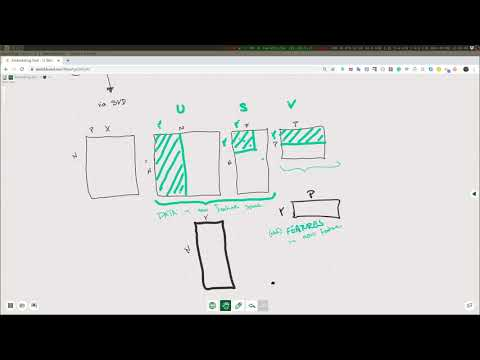

In [2]:
YouTubeVideo('V2PorP6oMLY', width=640,height=360)

In [3]:
docs = ['"I dont believe people who see ghosts", said Mannie, before spitting into the wind and riding his bike down the street at top speed. He then went home and ate peanut-butter and jelly sandwiches all day with big glasses of milk, which he loves. Mannie really liked ghosts and he often told his mother so. He believed he saw them everywhere and that they existed to help us.',

        'People see incredible things. One time I saw some people talking about things they were seeing, and those people were so much fun. They saw clouds and they saw airplanes and they saw Ghosts. Ghosts were the most incredible things people saw. ',
        
        'We have collected a report of people in our community seeing ghosts. Each resident was asked "how many ghosts have you seen?", "describe the last ghost you saw", and "tell us about your mother." Afterwards, we compared the ghost reports between the different individuals, and assessed whether or not they were actually seeing these apparitions.',

        'This is an article about a circus. A Circus is where people go to see other people who perform great things. Circuses also have elephants and tigers, which generally get a big woop from the crowd. People love the tigers.',

        'Goat milk is essential for strong bones. We recommend drinking much goat milk, people of all ages should drink goat milk. Tigers milk is also essential.',

        'Goats are lovely creatures. Many people love goats. People who love goats love seeing them play in the fields.',

        'There are many types of milk in the world, from elephants, cows, sheep, tiger, mothers, etc. Each of these milks are important for building strong bodies and healthy bones. ']

## **Exercise 1**

Create a document-term matrix from `docs` (this will probably be a copy-paste of code from last week!). Be fairly aggressive with your vocabulary pruning (feel free to look at the settings I use in the `solutions.py` for the vectorizer). 

Get the "loadings" matrix of the firsst 2 dimensions of PCA run on your document-term matrix. This is the $V^T$ from the SVD decomposition (HINT: this is the `.components_` of `sklearn` PCA models. Also, you can use `TruncatedSVD` to have a model that works on sparse matrices as well, even though its not needed in these toy examples).

Plot the 2-dimensional word vectors in a scatter plot with labels for each word. What do you think of how they are laid out? 

In [4]:
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

not_alphanumeric_or_space = re.compile(r'[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

In [15]:
def preprocess(docs):
    docs_words = []
    for d in docs:
        docs1 = re.sub(not_alphanumeric_or_space, '', d.lower())
        docs2 = str(docs1).strip()
        docs3 = [token.lemma_ for token in nlp(docs2) if token.lemma_ != '-PRON-']
        docs4 = ' '.join(docs3)
        docs_words.append(docs4)   
    return(docs_words)

In [27]:
vectorizer = TfidfVectorizer(min_df=2,
                             max_df=.8,
                             stop_words='english',
                             use_idf=False,
                             norm=False)
docs = preprocess(docs)
vec = vectorizer.fit_transform(docs)
vec = vec.todense()

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vec)
loadings = pca.components_
vocab = [i[0] for i in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]

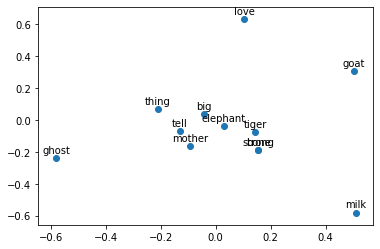

In [67]:
plt.scatter(loadings[0,:],loadings[1,:])
for x,y,v in zip(loadings[0,:],loadings[1,:],vocab):
    plt.annotate(v, 
                 (x,y), # coordinates of point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')

This partially makes sense. For instance, 'bone' is close to 'strong', and 'elephant' is close to 'tiger'. However, a lot of other word associations are not reflected, such as 'mother' or 'goat' with 'milk'. 

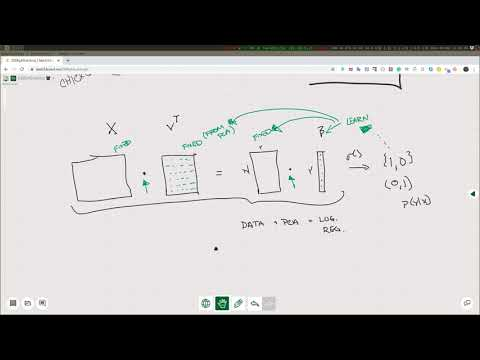

In [70]:
YouTubeVideo('zR01I04XP9A', width=640,height=360)


## **Exercise 2**

As per the video, learn an embedding matrix, $W$, such that $\sigma(XW\beta)$ predicts class y in our documents. Initialize the matrix $W$ with $V^T$ from the SVD decomposition of your document-term-frequency matrix $X$.

Use `pytorch` to solve this problem. You don't need any neural network infrastructure, it's very simple with just matrix multiplication and gradients.

Remember, this is just logistic regression in a latent space, and that latent space is defined by a linear mapping ($W$) that is learned at the same time as the coefficients of the logistic regression.


[This tutorial in the pytorch documentation gives you what you need!](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

I also encourage you to look at the solutions if you are new to `pytorch`, you will have another chance in a later exercise to play with it on your own!

In [165]:
# use y as your prediction target:

y = np.array([0,0,0,1,1,1,1]).reshape(-1, 1)

In [166]:
import torch

Y = torch.tensor(y, dtype=torch.float32)
X = torch.tensor(vec, dtype=torch.float32)
W = torch.tensor(loadings.transpose(), dtype=torch.float32,requires_grad=True)
beta = torch.randn(2,1,requires_grad=True)

opt = torch.optim.Adam([W, beta], lr=0.01)
criterion = torch.nn.BCELoss()

for i in range(500):
    L = torch.mm(X, W)
    out = torch.mm(L, beta)
    p = torch.sigmoid(out)
    loss = criterion(p, Y)
    if i % 20 == 0:
        print(loss)
    loss.backward()
    opt.step()
    opt.zero_grad()

tensor(1.0599, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6590, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4672, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2553, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1053, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0160, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0114, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0087, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0056, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0039, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0034, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0030, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0026, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0023, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0021, grad_fn=<BinaryCrossEntropyBack

In [167]:
w_out = W.detach().numpy().transpose()
beta_out = beta.detach().numpy()

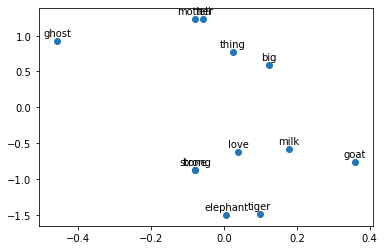

In [169]:
plt.scatter(w_out[0,:],w_out[1,:])
for x,y,v in zip(w_out[0,:],w_out[1,:],vocab):
    plt.annotate(v, 
                 (x,y), # coordinates of point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')

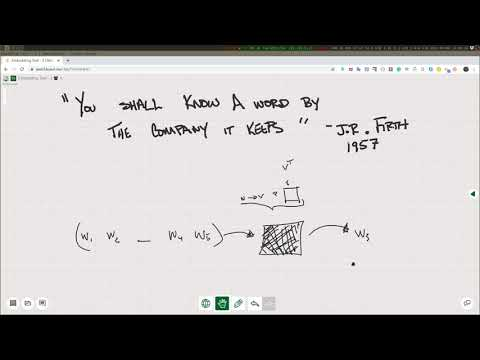

In [171]:
YouTubeVideo('YYdQhbnbqsw', width=640,height=360)

**Assignment**

The assignment is related to Word2Vec! Feel free to complete it now :)

In [ ]:
YouTubeVideo('h6J1-SB_Bno', width=640,height=360)


## **Exercise 3**
Let's take a look at how PCA is reconstructing the cooccurrence matrix of the terms within documents. 

Plot a heatmap of $X^TX$ and a heatmap of $ww^T$ where $w$ is is learned mapping of from word space into the reduced dimensional space of the PCA (i.e. $w = V^T$ from the SVD decomposition of hte $X$ matrix)

Does the two matrices seem qualitatively similar, from their heatmaps? 

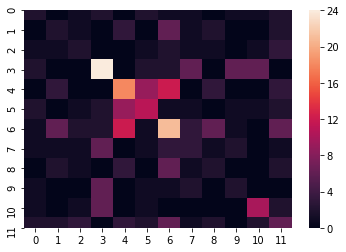

In [175]:
sns.heatmap(np.matmul(vec.transpose(),vec))

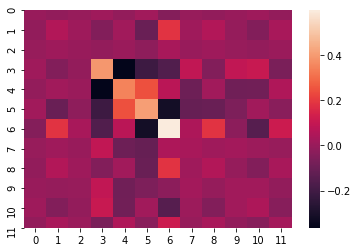

In [177]:
sns.heatmap(np.matmul(loadings.transpose(),loadings))

## **Exercise 4**

Let's try and reconstuct a cooccurrence matrix that takes word position into account. You can think of this as a simplified version of GloVe! We will see if the embeddings differ qualitatively. 

First, create a coccurrence matrix where the value of i,j is incremented by $1/D$ (where $D$ is the distance between two words) every time two words cooccurr in the same document. Plot it out in a heatmap, compare it to the previous two heatmaps. How does it differ? 

Second, learn a new 2-dimensional word embedding, $w$, that minimizes the frobenius norm of the distance between the target matrix (the cooccurrence matrix you constructed) and the matrix $ww^T$. Use pytorch to optimize the problem. 

Third, plot your learned 2-dimensional word embeddings. How do they compare to the other embeddings? 


In [181]:
vocab

['big',
 'bone',
 'elephant',
 'ghost',
 'goat',
 'love',
 'milk',
 'mother',
 'strong',
 'tell',
 'thing',
 'tiger']

In [180]:
vec

matrix([[1., 0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 3., 0.],
        [0., 0., 0., 4., 0., 0., 0., 1., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2.],
        [0., 1., 0., 0., 3., 0., 4., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 3., 3., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1.]])

In [200]:
np.matmul(vec.transpose(),vec)

matrix([[ 2.,  0.,  1.,  2.,  0.,  2.,  1.,  1.,  0.,  1.,  1.,  2.],
        [ 0.,  2.,  1.,  0.,  3.,  0.,  6.,  1.,  2.,  0.,  0.,  2.],
        [ 1.,  1.,  2.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  1.,  3.],
        [ 2.,  0.,  0., 24.,  0.,  2.,  2.,  6.,  0.,  6.,  6.,  0.],
        [ 0.,  3.,  0.,  0., 18.,  9., 12.,  0.,  3.,  0.,  0.,  3.],
        [ 2.,  0.,  1.,  2.,  9., 11.,  1.,  1.,  0.,  1.,  1.,  2.],
        [ 1.,  6.,  2.,  2., 12.,  1., 21.,  3.,  6.,  1.,  0.,  6.],
        [ 1.,  1.,  1.,  6.,  0.,  1.,  3.,  3.,  1.,  2.,  0.,  1.],
        [ 0.,  2.,  1.,  0.,  3.,  0.,  6.,  1.,  2.,  0.,  0.,  2.],
        [ 1.,  0.,  0.,  6.,  0.,  1.,  1.,  2.,  0.,  2.,  0.,  0.],
        [ 1.,  0.,  1.,  6.,  0.,  1.,  0.,  0.,  0.,  0., 10.,  2.],
        [ 2.,  2.,  3.,  0.,  3.,  2.,  6.,  1.,  2.,  0.,  2.,  6.]])

In [249]:
weights = np.zeros((len(vocab),len(vocab)))
for i,d in enumerate(docs):
    words = d.split()
    for w in words:
        for m in words:
            if w in vocab and m in vocab:
                indi = vocab.index(w)
                indj = vocab.index(m)
                posi = d.index(w)
                posj = d.index(m)
                try:
                    weights[indi,indj] += 1/abs(posi-posj)
                except:
                    None

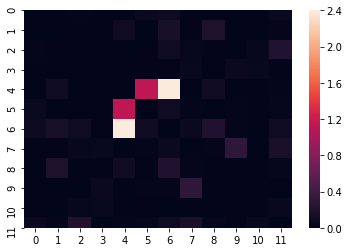

In [250]:
sns.heatmap(weights)

In [251]:
target = torch.tensor(weights, dtype=torch.float32)
w = torch.randn(weights.shape[0],2,requires_grad=True)

opt = torch.optim.Adam([w], lr=0.01)
# criterion = torch.dist()

for i in range(500):
    out = torch.mm(w,torch.transpose(w,0,1))
    loss = torch.dist(out, target)
    if i % 20 == 0:
        print(loss)
    loss.backward()
    opt.step()
    opt.zero_grad()

tensor(13.3850, grad_fn=<DistBackward>)
tensor(9.3001, grad_fn=<DistBackward>)
tensor(6.6780, grad_fn=<DistBackward>)
tensor(5.1710, grad_fn=<DistBackward>)
tensor(4.3725, grad_fn=<DistBackward>)
tensor(3.9080, grad_fn=<DistBackward>)
tensor(3.5370, grad_fn=<DistBackward>)
tensor(3.1714, grad_fn=<DistBackward>)
tensor(2.9113, grad_fn=<DistBackward>)
tensor(2.8032, grad_fn=<DistBackward>)
tensor(2.7523, grad_fn=<DistBackward>)
tensor(2.7286, grad_fn=<DistBackward>)
tensor(2.7166, grad_fn=<DistBackward>)
tensor(2.7098, grad_fn=<DistBackward>)
tensor(2.7058, grad_fn=<DistBackward>)
tensor(2.7032, grad_fn=<DistBackward>)
tensor(2.7014, grad_fn=<DistBackward>)
tensor(2.7001, grad_fn=<DistBackward>)
tensor(2.6990, grad_fn=<DistBackward>)
tensor(2.6981, grad_fn=<DistBackward>)
tensor(2.6972, grad_fn=<DistBackward>)
tensor(2.6964, grad_fn=<DistBackward>)
tensor(2.6955, grad_fn=<DistBackward>)
tensor(2.6945, grad_fn=<DistBackward>)
tensor(2.6934, grad_fn=<DistBackward>)


In [252]:
w_new = w.detach().numpy().transpose()

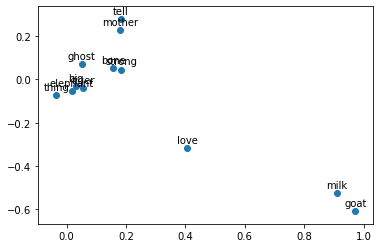

In [253]:
plt.scatter(w_new[0,:],w_new[1,:])
for x,y,v in zip(w_new[0,:],w_new[1,:],vocab):
    plt.annotate(v, 
                 (x,y), # coordinates of point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')